In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)


import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters


from grav_lens import get_datasets
max_files = 900
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



IncrementalPCA(batch_size=64, n_components=64)
Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [2]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm,reconstruct_highfreq_from_gmm, reconstruct_lowfreq_from_pca, reconstruct_batch_images

In [15]:
def preprocess_ybatch(y_batch):
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

# Visualización

In [4]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch, 40, 0, 1)

c

(64, 128, 128, 3)
(64, 128, 128, 1)


In [5]:
principal_components.shape

(64, 64)

(array([  1.,   3.,   1.,   0.,   4.,   9.,  10.,  20.,  39.,  61., 105.,
        183., 400., 571., 742., 733., 526., 303., 179.,  82.,  48.,  28.,
         15.,   8.,   6.,   3.,   2.,   3.,   1.,   1.,   0.,   2.,   2.,
          1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.41389303, -2.25142875, -2.08896446, -1.92650017, -1.76403589,
        -1.6015716 , -1.43910731, -1.27664303, -1.11417874, -0.95171445,
        -0.78925017, -0.62678588, -0.46432159, -0.30185731, -0.13939302,
         0.02307127,  0.18553555,  0.34799984,  0.51046412,  0.67292841,
         0.8353927 ,  0.99785698,  1.16032127,  1.32278556,  1.48524984,
         1.64771413,  1.81017842,  1.9726427 ,  2.13510699,  2.29757128,
         2.46003556,  2.62249985,  2.78496414,  2.94742842,  3.10989271,
         3.272357  ,  3.43482128,  3.59728557,  3.75974986,  3.92221414,
         4.08467843,  4.24714271,  4.409607  ,  4.57207129,  4.73453557,
 

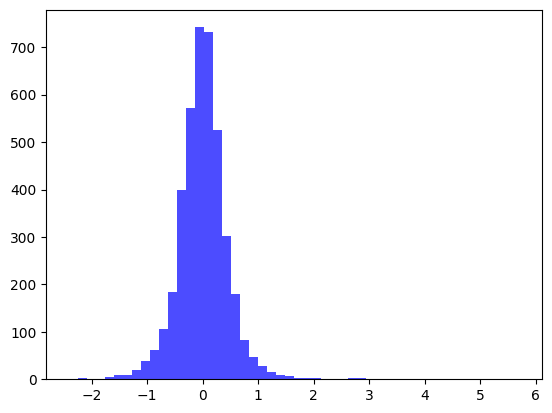

In [12]:
plt.hist(principal_components.flatten(), bins=50, alpha=0.7, color='blue')


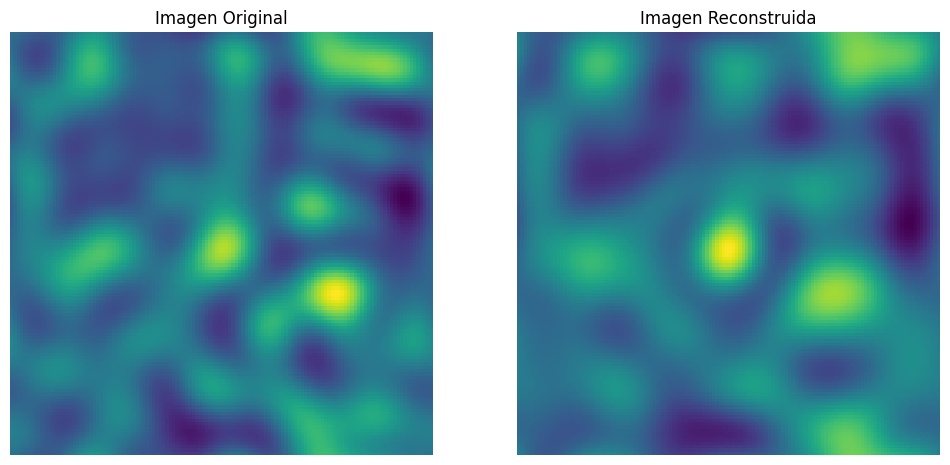

In [6]:
low_recon = reconstruct_lowfreq_from_pca(principal_components, 64, ipca_low)

idx = 0
original = low_batch[idx,:,:,0]
reconstructed = low_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

In [7]:
from grav_lens.preprocess.gmm import generate_points_around_peaks
from grav_lens.utils import get_stats

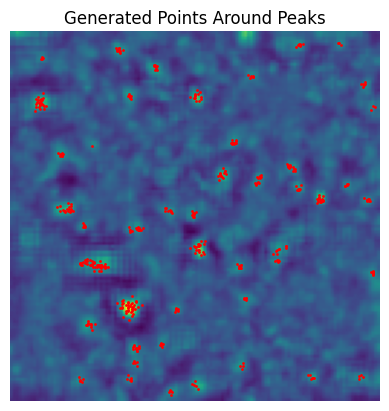

In [8]:
from skimage.feature import peak_local_max


idx = 9
original = high_batch[idx,:,:,0]
batch_mean, batch_std = get_stats(high_batch)
coordinates = peak_local_max(original, min_distance=1, threshold_abs=batch_mean + 2*batch_std)

# Generar puntos alrededor de los picos
points = generate_points_around_peaks(original, coordinates, n_samples=500, std_factor=10.0)

# Visualizar los puntos generados
plt.imshow(original, cmap='viridis')
plt.plot(points[:, 1], points[:, 0], 'r.', markersize=2)
plt.axis('off')
plt.title('Generated Points Around Peaks')
plt.show()

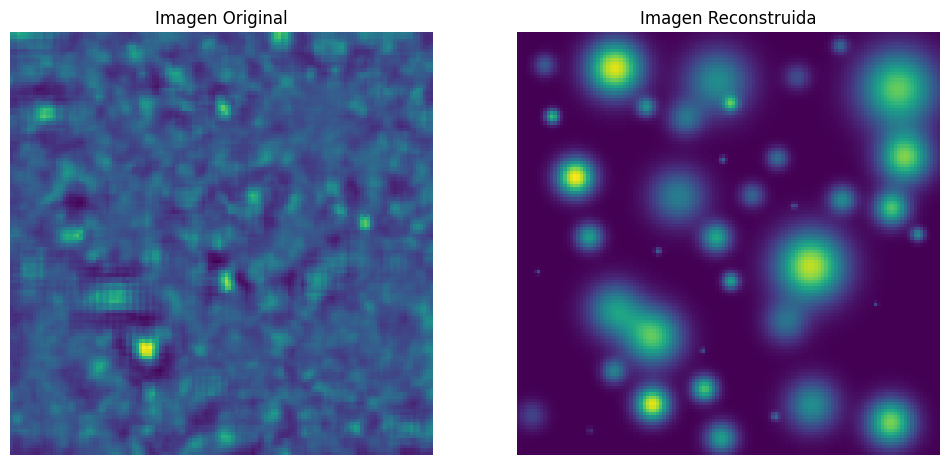

In [9]:
reconstructed_batch=reconstruct_highfreq_from_gmm(gaussians, 64)
idx = 9
original = high_batch[idx,:,:,0]
reconstructed = reconstructed_batch[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

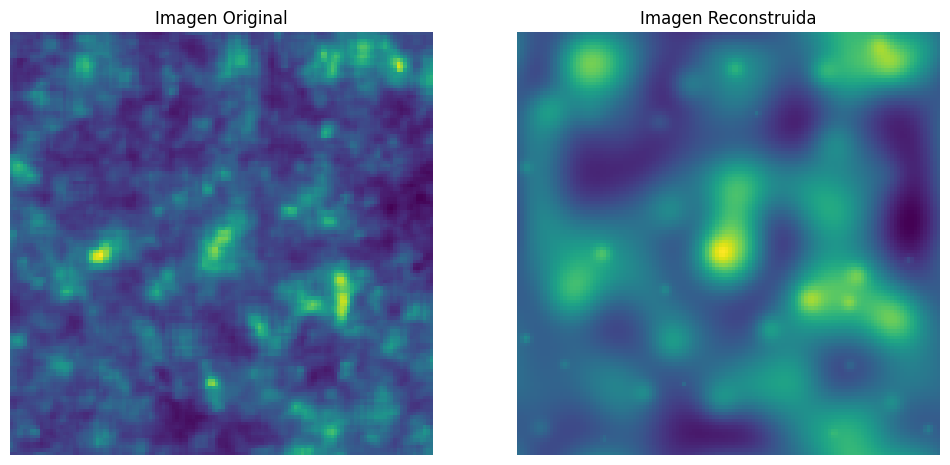

In [10]:
reconstructed_batch = reconstruct_batch_images(principal_components,gaussians,64, ipca_low)

idx = 0
original = y_batch[idx,:,:,0]
reconstructed = reconstructed_batch[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

# Histogramas

In [11]:
plot_histograms(*preprocess_ybatch(y_batch))

NameError: name 'plot_histograms' is not defined

# GMM por detras

In [24]:
from sklearn.mixture import GaussianMixture
import cv2

In [25]:

from skimage.feature import peak_local_max

def generate_points_from_image_peaks(image, threshold_abs=0.01, min_distance=1):
    """
    Genera puntos (x, y) a partir de una imagen identificando los máximos locales, junto con un peso proporcional a la intensidad
    del pixel en cada punto.

    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        threshold_abs (float, opcional): Umbral absoluto para ignorar píxeles de baja densidad (por defecto 0.01).
        min_distance (int, opcional): Distancia mínima entre picos locales (por defecto 1).

    Retorna:
        points (numpy array): Array de coordenadas (x, y) generadas a partir de los valores de los picos locales.
        points_weights (numpy array): Pesos de los puntos generados, proporcionales a la intensidad del pixel.
    """
    # Verificar si la imagen está vacía (todos los valores son cero)
    if np.sum(image) == 0:
        # Si está vacía, devolver una lista vacía de puntos
        return np.array([])

    # Encontrar los picos locales de la imagen
    coordinates = peak_local_max(image, min_distance=min_distance, threshold_abs=threshold_abs)

    # # Obtener los pesos correspondientes a la intensidad del pixel en cada coordenada detectada
    # points_weights = image[coordinates[:, 0], coordinates[:, 1]]

    return coordinates #, points_weights


def generate_points_around_peaks(image, peak_coordinates, n_samples=500, std_factor=1.0):
    """
    Genera puntos alrededor de los picos de una imagen usando una distribución gaussiana.

    Parámetros:
        image (numpy.ndarray): La imagen original (2D).
        peak_coordinates (numpy.ndarray): Coordenadas de los picos (N_p, 2), donde N_p es el número de picos.
        n_samples (int): Número total de puntos a generar.
        std_factor (float): Factor para escalar la desviación estándar de la distribución gaussiana.

    Retorna:
        points (numpy.ndarray): Array de coordenadas (x, y) generadas a partir de los picos.
    """
    # Obtener la intensidad en cada uno de los picos
    intensities = image[peak_coordinates[:, 0], peak_coordinates[:, 1]]
    probabilities = intensities / intensities.sum()

    # Calcular cuántos puntos se generarán alrededor de cada pico
    n_points_per_peak = np.random.multinomial(n_samples, probabilities)

    # Inicializar lista de puntos
    points = []

    for i, (y, x) in enumerate(peak_coordinates):
        # Desviación estándar proporcional a la intensidad del pico
        std_dev = std_factor * intensities[i]

        # Generar puntos alrededor del pico
        x_points = np.random.normal(loc=x, scale=std_dev, size=n_points_per_peak[i])
        y_points = np.random.normal(loc=y, scale=std_dev, size=n_points_per_peak[i])

        # Agregar puntos a la lista
        points.append(np.column_stack((y_points, x_points)))

    # Concatenar todos los puntos generados
    points = np.vstack(points)

    # Filtrar puntos que se salen de los límites de la imagen
    points = points[(points[:, 0] >= 0) & (points[:, 0] < image.shape[0]) & 
                    (points[:, 1] >= 0) & (points[:, 1] < image.shape[1])]

    return points


In [46]:
# Nueva función para escalar las gaussianas
def scale_gaussian_parameters(means, covariances, scale):
    """
    Escala los parámetros de las gaussianas (medias y covarianzas) para ajustar la resolución original.
    
    Parámetros:
        means (numpy array): Medias (x, y) de las gaussianas.
        covariances (numpy array): Covarianzas (matriz 2x2) de las gaussianas.
        scale (float): Factor de escalado inverso para volver a la resolución original.
    
    Retorna:
        scaled_means (numpy array): Medias escaladas.
        scaled_covariances (numpy array): Covarianzas escaladas.
    """
    scaled_means = means / scale  # Escalar las medias
    scaled_covariances = covariances / (scale ** 2)  # Escalar las covarianzas (cuadrado del factor de escala)
    return scaled_means, scaled_covariances


def downscale_image(image, scale=0.5):
    """
    Escala la imagen a la mitad de su resolución.
    """
    height, width = image.shape[:2]
    new_dim = (int(width * scale), int(height * scale))
    return cv2.resize(image, new_dim, interpolation=cv2.INTER_AREA)




# Función para aplicar el GMM en imágenes escaladas
def gmm_batch_vectors(batch, n_gaussians_positive=30, n_gaussians_negative=10, threshold=2, n_points=500, 
                      scale=0.5, density_threshold=0.05, density_scaling=True,
                      pos_reg_covar=1e-6, pos_tol=1e-3, neg_reg_covar=1e-6, neg_tol=1e-3):
    """
    Aplica modelos de mezclas gaussianas (GMM) a un batch de imágenes escaladas, generando vectores de medias, desviaciones estándar y pesos.
    Luego, reescala las gaussianas para que correspondan a la resolución original y las ordena por la magnitud de sus pesos.


    Esta función primero reduce la resolución de las imágenes de entrada, aplica un modelo GMM para extraer las componentes gaussianas
    positivas y negativas, y finalmente reescala las gaussianas a la resolución original. Se usa para aproximar las distribuciones
    de alta y baja frecuencia en las imágenes.

    Parámetros:
        batch (numpy.ndarray):  Batch de imágenes a procesar con shape (batch_size, altura, anchura, 1).
        n_gaussians_positive (int, opcional):   Número de componentes gaussianas positivas (por defecto 30).
        n_gaussians_negative (int, opcional):   Número de componentes gaussianas negativas (por defecto 10).
        threshold (float, opcional):    Umbral para separar las frecuencias. Define qué partes de la imagen se consideran "positivas" o "negativas" (por defecto 2).
        n_points (int, opcional):   Número de puntos a generar para el modelo GMM a partir de la imagen umbralizada (por defecto 500).
        scale (float, opcional):    Factor de escalado de la imagen para reducir la resolución (por defecto 0.5).
        pos_reg_covar (float, opcional):    Regularización aplicada a las covariancias de las gaussianas positivas (por defecto 1e-3).
        pos_tol (float, opcional):  Tolerancia para la convergencia del GMM positivo (por defecto 1e-5).
        neg_reg_covar (float, opcional):    Regularización aplicada a las covariancias de las gaussianas negativas (por defecto 1e-3).
        neg_tol (float, opcional):  Tolerancia para la convergencia del GMM negativo (por defecto 1e-5).

    Retorna:
        numpy.ndarray:  Batch de vectores combinados con shape (batch_size, n_gaussianas, 5). Cada vector tiene el formato 
                       [mean_x, mean_y, std_x, std_y, weight], donde mean_x y mean_y son las medias de la gaussiana,
                       std_x y std_y son las desviaciones estándar, y weight es el peso de la gaussiana.

    Notas:
        - Se aplica un escalado a las imágenes antes de calcular las gaussianas, lo que reduce la cantidad de detalles procesados.
        - Después de aplicar GMM, los parámetros gaussianos se reescalan a la resolución original.
        - Esta función es útil para capturar tanto las frecuencias altas como bajas de la imagen usando GMM en distintas resoluciones.

    Ejemplo:
        >>> batch = np.random.random((10, 128, 128, 1))
        >>> result = gmm_batch_vectors(batch, n_gaussians_positive=20, n_gaussians_negative=5, scale=0.5)
        >>> result.shape
        (10, 25, 5)
    """
    batch_size = batch.shape[0]
    combined_batch = []
    original_shape = batch.shape[1:3]  # Obtener la forma original (altura, anchura)
    mean, std = gp.calculate_image_stats(batch)

    for i in range(batch_size):
        img = batch[i, :, :, 0]  # Tomamos cada imagen del batch

        # Escalar la imagen
        img_scaled = downscale_image(img, scale=scale)

        # Aplicar umbrales y calcular GMMs en la imagen escalada
        img_clear_positive, img_clear_negative = gp.apply_threshold(img_scaled, mean, std, threshold)

        # Verificar si hay puntos en la parte positiva

        #points = generate_points_from_image(img_clear_positive, n_samples=n_points, density_threshold=density_threshold, density_scaling=density_scaling)

        coordinates = generate_points_from_image_peaks(img_clear_positive, threshold_abs=mean + threshold * std, min_distance=1)

        # Generar puntos alrededor de los picos
        points = generate_points_around_peaks(img_clear_positive, coordinates, n_samples=n_points, std_factor=10.0)


        # Cambiar la lógica de generación del GMM positivo
        if len(points) == 0:
            means = np.zeros((n_gaussians_positive, 2))
            covariances = np.eye(2).reshape((1, 2, 2)).repeat(n_gaussians_positive, axis=0)
            weights = np.zeros(n_gaussians_positive)
        else:
            # Ajustar el número de componentes gaussianas dinámicamente
            n_components = min(len(points), n_gaussians_positive)
            gmm = GaussianMixture(n_components=n_components, covariance_type='spherical',
                                  reg_covar=pos_reg_covar, tol=pos_tol).fit(points)
            means = gmm.means_
            covariances = gmm.covariances_
            weights = gmm.weights_

            # Si el número de gaussianas es menor que n_gaussians_positive, rellena con ceros
            if n_components < n_gaussians_positive:
                padding = n_gaussians_positive - n_components
                means = np.pad(means, ((0, padding), (0, 0)), mode='constant')
                covariances = np.pad(covariances, ((0, padding), (0, 0), (0, 0)), mode='constant')
                weights = np.pad(weights, (0, padding), mode='constant')

        combined_means = means
        combined_covariances = covariances
        combined_weights = weights

        # Solo calcular la parte negativa si n_gaussians_negative > 0
        if n_gaussians_negative > 0:
            
            coordinates = generate_points_from_image_peaks(-img_clear_negative, threshold_abs=mean + threshold * std, min_distance=1)
            # Generar puntos alrededor de los picos
            negative_points = generate_points_around_peaks(-img_clear_negative, coordinates, n_samples=n_points, std_factor=10.0)

            if len(negative_points) == 0:
                means_negative = np.zeros((n_gaussians_negative, 2))
                covariances_negative = np.eye(2).reshape((1, 2, 2)).repeat(n_gaussians_negative, axis=0)
                weights_negative = np.zeros(n_gaussians_negative)
            else:
                gmm_negative = GaussianMixture(n_components=n_gaussians_negative, covariance_type='spherical',
                                               reg_covar=neg_reg_covar, tol=neg_tol).fit(negative_points)
                means_negative = gmm_negative.means_
                covariances_negative = gmm_negative.covariances_
                weights_negative = -gmm_negative.weights_

            # Concatenar los resultados de las gaussianas negativas
            combined_means = np.vstack([combined_means, means_negative])
            combined_covariances = np.vstack([combined_covariances, covariances_negative])
            combined_weights = np.hstack([combined_weights, weights_negative])

        # Reescalar las gaussianas a la resolución original ---------------------
        combined_means, combined_covariances = scale_gaussian_parameters(combined_means, combined_covariances, scale)

        # Extraer las desviaciones estándar (componentes diagonales de las covariancias)
        # std_x = np.sqrt(combined_covariances[:, 0, 0])  # Desviación estándar en el eje x
        # std_y = np.sqrt(combined_covariances[:, 1, 1]) # Desviación estándar en el eje y

        std_x = np.sqrt(combined_covariances)  # Desviación estándar en el eje x
        std_y = np.sqrt(combined_covariances) # Desviación estándar en el eje y


        # Concatenar todos los valores relevantes en un vector (mean_x, mean_y, std_x, std_y, weight)
        combined_vectors = np.column_stack([combined_means[:, 0],  # mean_x
                                            combined_means[:, 1],  # mean_y
                                            std_x,                 # std_x
                                            std_y,                 # std_y
                                            combined_weights])     # weight

        # Ordenar las gaussianas por el valor absoluto de los pesos
        sorted_indices = np.argsort(-np.abs(combined_weights))  # Ordenar de mayor a menor
        combined_vectors = combined_vectors[sorted_indices]

        combined_batch.append(combined_vectors)

    # Convertir la lista en un numpy array con shape (batch_size, n_gaussianas, 5)
    combined_batch = np.array(combined_batch)

    return combined_batch


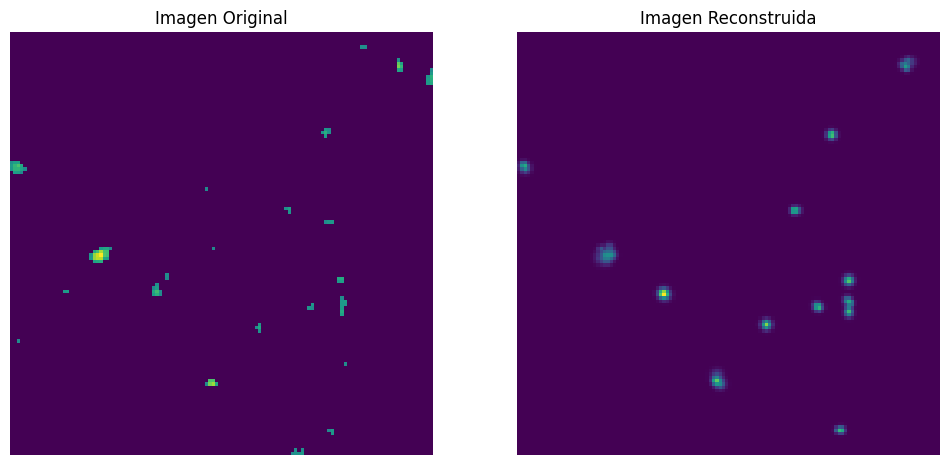

In [47]:
import grav_lens.preprocess as gp

corte = 3

mean, std = gp.calculate_image_stats(high_batch)
pos_hb, neg_hb = gp.apply_threshold(high_batch[idx,:,:,0], mean, std, corte)

# se agregaron tecnicas de regularización
gaussians = gmm_batch_vectors(high_batch, n_gaussians_positive=30, n_gaussians_negative=0, 
                                 threshold=corte, n_points=1000, scale=0.75, density_threshold=0.01)

high_recon = reconstruct_highfreq_from_gmm(gaussians, 64)

idx = 0
original = pos_hb
reconstructed = high_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)